# Covid Pneumonia detection

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


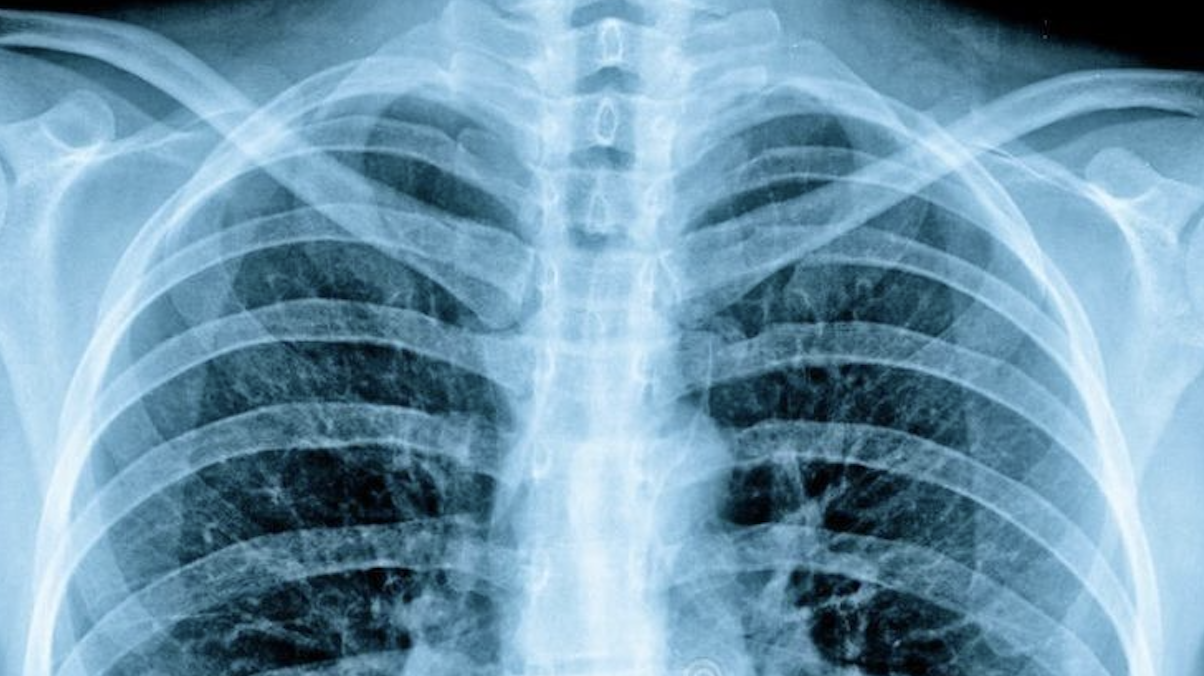

## Sources

Database of COVID-19 X-ray images from the Italian Society of Medical and Interventional Radiology (SIRM) COVID-19 DATABASE, the Novel Coronavirus 2019 Dataset developed by Joseph Paul Cohen, Paul Morrison, and Lan Dao on GitHub, and images extracted from 43 different publications. References for each image are provided. Normal and viral pneumonia images were taken from the Chest X-Ray Images (Pneumonia) database. The link to the data is as follows:https://www.kaggle.com/tawsifurrahman/covid19-radiography-database

In [ ]:
zip_file = '/content/drive/MyDrive/Colab_Notebooks/Project_pneumonia/zip_Covid_pneumonia_datasets.zip'
directory = '/content/drive/MyDrive/Colab_Notebooks/Project_pneumonia'

In [ ]:
!unzip "{zip_file}" -d "{directory}"

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/Colab_Notebooks/Project_pneumonia/Covid_pneumonia_datasets/Covid/images/COVID-3264.png  
  inflating: /content/drive/MyDrive/Colab_Notebooks/Project_pneumonia/__MACOSX/Covid_pneumonia_datasets/Covid/images/._COVID-3264.png  
  inflating: /content/drive/MyDrive/Colab_Notebooks/Project_pneumonia/Covid_pneumonia_datasets/Covid/images/COVID-1473.png  
  inflating: /content/drive/MyDrive/Colab_Notebooks/Project_pneumonia/__MACOSX/Covid_pneumonia_datasets/Covid/images/._COVID-1473.png  
  inflating: /content/drive/MyDrive/Colab_Notebooks/Project_pneumonia/Covid_pneumonia_datasets/Covid/images/COVID-2393.png  
  inflating: /content/drive/MyDrive/Colab_Notebooks/Project_pneumonia/__MACOSX/Covid_pneumonia_datasets/Covid/images/._COVID-2393.png  
  inflating: /content/drive/MyDrive/Colab_Notebooks/Project_pneumonia/Covid_pneumonia_datasets/Covid/images/COVID-1842.png  
  inflating: /content/drive/MyDrive/Colab

## Problematic

The process of detecting pneumonia in X-rays requires significant expertise and analysis time. Specifically, distinguishing COVID-19 pneumonia from other viral pneumonias presents considerable challenges for the medical profession and radiologists. Developing an effective model for detecting COVID-19 pneumonia in radiographic images is crucial for several reasons:

* It enables faster diagnosis of COVID-19.

* It provides a complementary diagnosis that may surpass the accuracy of radiologists.

* It reduces costs by using radiography more frequently instead of more expensive imaging techniques such as MRI, CT, and nuclear medicine.

Summary

##Preprocessing

##Crop Images

In [13]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import concurrent.futures
import shutil
import random

tf.__version__

'2.17.1'

Replace spaces in file names with underscores.

In [ ]:
import os

def replace_spaces_with_underscores(folder_path):
    if not os.path.exists(folder_path):
        print(f"Le dossier '{folder_path}' n'existe pas.")
        return

    for filename in os.listdir(folder_path):
        old_path = os.path.join(folder_path, filename)
        if os.path.isfile(old_path):
            new_filename = filename.replace(" ", "_")
            new_path = os.path.join(folder_path, new_filename)
            os.rename(old_path, new_path)
            print(f"Renommé : {filename} -> {new_filename}")

folder_path = '/content/drive/MyDrive/Colab_Notebooks/Project_pneumonia/Covid_pneumonia_datasets/Viral_Pneumonia/images'
replace_spaces_with_underscores(folder_path)


Renommé : Viral Pneumonia-770.png -> Viral_Pneumonia-770.png
Renommé : Viral Pneumonia-1186.png -> Viral_Pneumonia-1186.png
Renommé : Viral Pneumonia-1192.png -> Viral_Pneumonia-1192.png
Renommé : Viral Pneumonia-764.png -> Viral_Pneumonia-764.png
Renommé : Viral Pneumonia-994.png -> Viral_Pneumonia-994.png
Renommé : Viral Pneumonia-980.png -> Viral_Pneumonia-980.png
Renommé : Viral Pneumonia-758.png -> Viral_Pneumonia-758.png
Renommé : Viral Pneumonia-1145.png -> Viral_Pneumonia-1145.png
Renommé : Viral Pneumonia-1151.png -> Viral_Pneumonia-1151.png
Renommé : Viral Pneumonia-957.png -> Viral_Pneumonia-957.png
Renommé : Viral Pneumonia-1179.png -> Viral_Pneumonia-1179.png
Renommé : Viral Pneumonia-943.png -> Viral_Pneumonia-943.png
Renommé : Viral Pneumonia-214.png -> Viral_Pneumonia-214.png
Renommé : Viral Pneumonia-572.png -> Viral_Pneumonia-572.png
Renommé : Viral Pneumonia-566.png -> Viral_Pneumonia-566.png
Renommé : Viral Pneumonia-200.png -> Viral_Pneumonia-200.png
Renommé : Vira

Let's display the inital images.

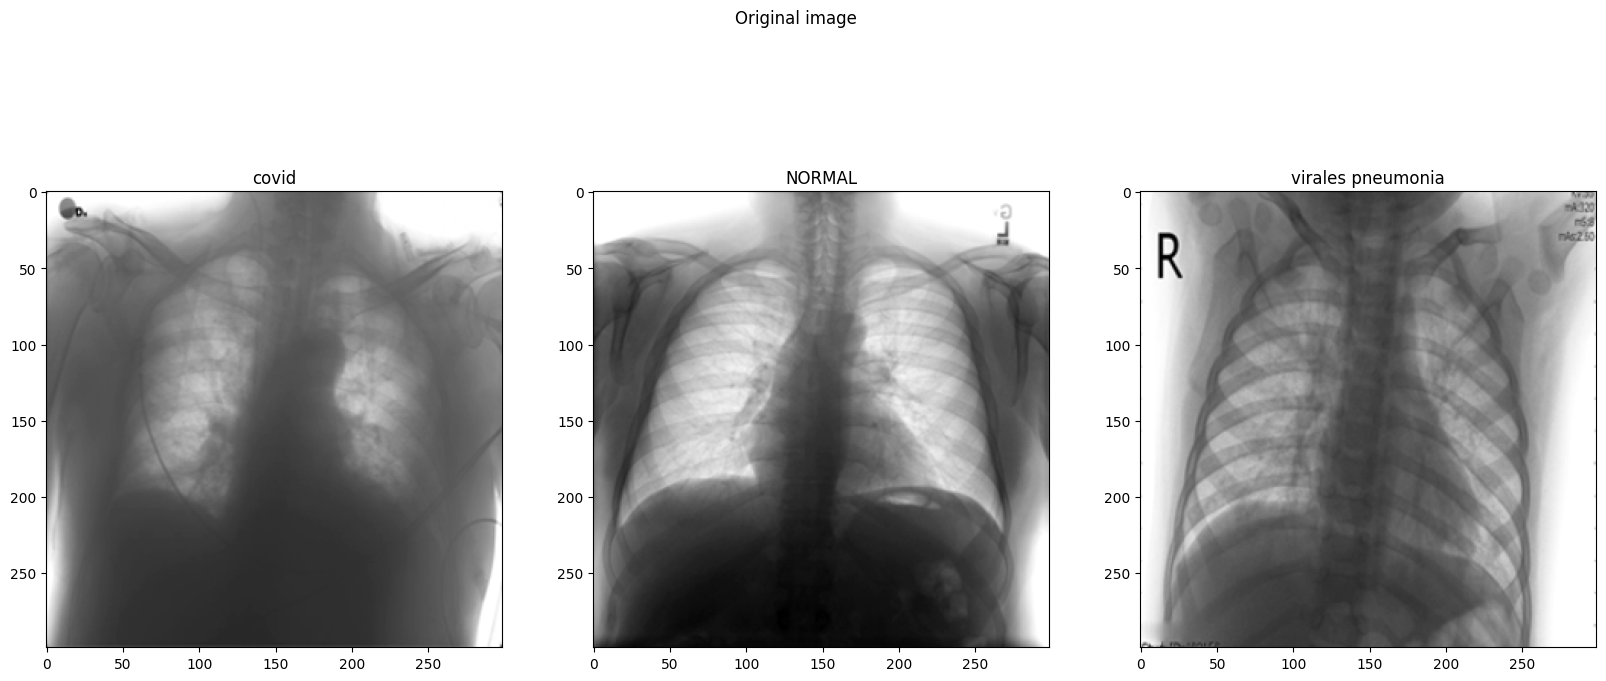

covid shape :
(299, 299)
Normal shape :
(299, 299)
virale pneumonia shpae :
(299, 299)


In [4]:
plt.figure(figsize=(20,20))



plt.subplot(1,3,1)
img = cv2.imread('/content/drive/MyDrive/Colab_Notebooks/Project_pneumonia/data/Covid/images/COVID-1.png',0)
plt.imshow(img, cmap='binary')
plt.title('covid')



plt.subplot(1,3,2)
img2 = cv2.imread("/content/drive/MyDrive/Colab_Notebooks/Project_pneumonia/data/Normal/images/Normal-7.png",0)
plt.imshow(img2 , cmap='binary')
plt.title('NORMAL')



plt.subplot(1,3,3)
img3= cv2.imread("/content/drive/MyDrive/Colab_Notebooks/Project_pneumonia/data/Viral_Pneumonia/images/Viral_Pneumonia-1.png",0)
plt.imshow(img3 , cmap='binary')
plt.title('virales pneumonia')


plt.suptitle("Original image", x = 0.5,y=0.7)


plt.show()

print('covid shape :')
print(img.shape)
print('Normal shape :')
print(img2.shape)
print('virale pneumonia shpae :')
print(img3.shape)

Count the number of elements in each folder.

In [11]:
covid_images='/content/drive/MyDrive/Colab_Notebooks/Project_pneumonia/data/Covid/images'
normal_images='/content/drive/MyDrive/Colab_Notebooks/Project_pneumonia/data/Normal/images'
viral_images='/content/drive/MyDrive/Colab_Notebooks/Project_pneumonia/data/Viral_Pneumonia/images'

In [9]:
def count_files(directory):
    items = os.listdir(directory)
    files = [item for item in items if os.path.isfile(os.path.join(directory, item))]
    return len(files)

In [12]:
print('covid file :', count_files(covid_images))
print('healthy file :', count_files(normal_images))
print('viral pneumonia file :', count_files(viral_images))

covid file : 3616
healthy file : 10192
viral pneumonia file : 1345


Let's crop the images to focus on the lungs.

The aim is to focus on areas of interest and reduce environmental bias. Here, I attempt to crop and retain 90% of the image from the center. This method allows us to adjust the parameter to explore other results.  

In [ ]:
import os
import cv2

def crop_and_resize(input_directory, target_size=(299, 299)):
    output_directory = input_directory + "_cropped"
    os.makedirs(output_directory, exist_ok=True)

    for root, _, files in os.walk(input_directory):
        relative_path = os.path.relpath(root, input_directory)
        current_output_dir = os.path.join(output_directory, relative_path)
        os.makedirs(current_output_dir, exist_ok=True)

        for filename in files:
            if filename.endswith('.png') or filename.endswith('.jpg') or filename.endswith('.jpeg'):
                input_path = os.path.join(root, filename)
                output_path = os.path.join(current_output_dir, filename)

                img = cv2.imread(input_path)
                if img is None:
                    continue

                height, width = img.shape[:2]
                start_row, start_col = int(height * 0.10), int(width * 0.10)
                end_row, end_col = int(height * 0.90), int(width * 0.90)
                cropped_image = img[start_row:end_row, start_col:end_col]
                resized_image = cv2.resize(cropped_image, target_size, interpolation=cv2.INTER_LINEAR)

                cv2.imwrite(output_path, resized_image)

    return output_directory


I created a new directory and kept the original one.

In [ ]:
input_directory = "/content/drive/MyDrive/Colab_Notebooks/Project_pneumonia/Covid_pneumonia_datasets"
crop_and_resize(input_directory)

'/content/drive/MyDrive/Colab_Notebooks/Project_pneumonia/Covid_pneumonia_datasets_cropped'

Cropping Verification

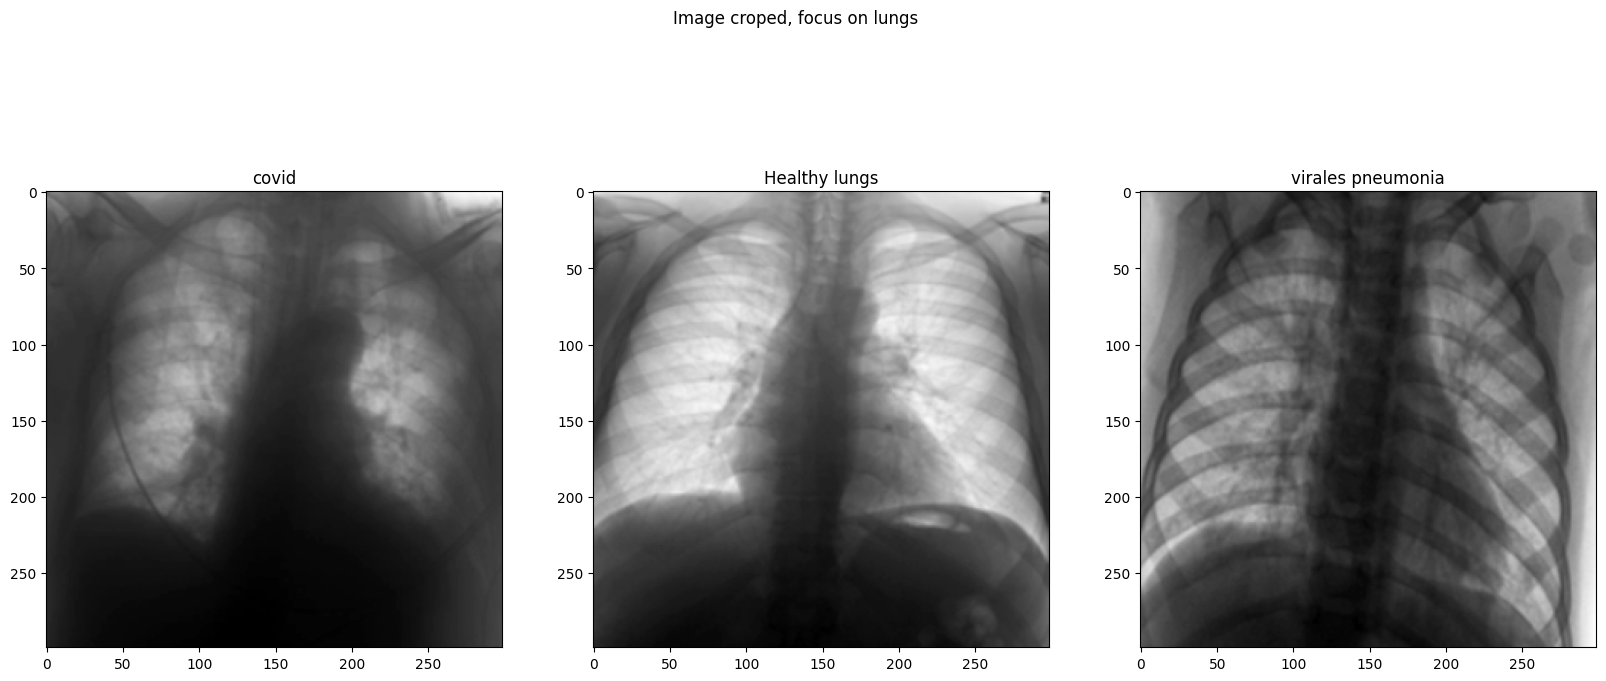

covid shape :
(299, 299)
Normal shape :
(299, 299)
virale pneumonia shape :
(299, 299)


In [13]:
plt.figure(figsize=(20,20))



plt.subplot(1,3,1)
img = cv2.imread('/content/drive/MyDrive/Colab_Notebooks/Project_pneumonia/data_cropped/Covid/images/COVID-1.png',0)
plt.imshow(img, cmap='binary')
plt.title('covid')



plt.subplot(1,3,2)
img2 = cv2.imread("/content/drive/MyDrive/Colab_Notebooks/Project_pneumonia/data_cropped/Normal/images/Normal-7.png",0)
plt.imshow(img2 , cmap='binary')
plt.title('Healthy lungs')



plt.subplot(1,3,3)
img3= cv2.imread("/content/drive/MyDrive/Colab_Notebooks/Project_pneumonia/data_cropped/Viral_Pneumonia/images/Viral_Pneumonia-1.png",0)
plt.imshow(img3 , cmap='binary')
plt.title('virales pneumonia')


plt.suptitle("Image croped, focus on lungs", x = 0.5,y=0.7)


plt.show()

print('covid shape :')
print(img.shape)
print('Normal shape :')
print(img2.shape)
print('virale pneumonia shape :')
print(img3.shape)

##Data Augmentation

In medical imaging tasks like pneumonia detection on chest X-rays, the diversity of data augmentation is limited because X-rays are acquired in controlled environments. The images usually share consistent quality, lighting, and structure. Excessive transformations, such as heavy rotations, flips, or shears, could distort critical features like opacities or lung abnormalities, leading the model to learn unrealistic patterns. Instead, we apply slight augmentations (small rotations, translations, or brightness adjustments) to improve robustness while preserving the diagnostic relevance of the images.

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_directory = '/content/drive/MyDrive/Colab_Notebooks/Project_pneumonia/data_cropped'
image_paths = []
labels = []
for root, dirs, files in os.walk(data_directory):
    for file in files:
        if file.endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(root, file))
            labels.append(root.split('/')[-2])


trainval_paths, test_paths, trainval_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.15, stratify=labels, random_state=42
)


train_paths, val_paths, train_labels, val_labels = train_test_split(
    trainval_paths, trainval_labels, test_size=0.20, stratify=trainval_labels, random_state=42
)


generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    brightness_range=[0.8, 1.2],
)


train_generator = generator.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': train_paths, 'class': train_labels}),
    x_col='filename',
    y_col='class',
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse',
    shuffle=True
)

val_generator = generator.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': val_paths, 'class': val_labels}),
    x_col='filename',
    y_col='class',
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse',
    shuffle=True
)

test_generator = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': test_paths, 'class': test_labels}),
    x_col='filename',
    y_col='class',
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)


Found 10304 validated image filenames belonging to 3 classes.
Found 2576 validated image filenames belonging to 3 classes.
Found 2273 validated image filenames belonging to 3 classes.


#Custom XCEPTION Model

In [ ]:
def build_model():
    input_tensor = tf.keras.Input(shape=(256, 256, 3))
    xception = tf.keras.applications.Xception(input_shape=(256, 256, 3),
                                              include_top=False,
                                              input_tensor=input_tensor)
    xception.trainable = False

    top_model = tf.keras.Sequential([
        tf.keras.layers.GlobalMaxPooling2D(),
        tf.keras.layers.Dense(4096, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(3, activation='softmax')
    ])

    model = tf.keras.Model(inputs=xception.input, outputs=top_model(xception.output))

    model.compile(
        optimizer='Adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )

    return model

In [ ]:
model = build_model()
model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 127, 127, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 127, 127, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 127, 127, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 125, 125, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 125, 125, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 125, 125, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 125, 125, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 125, 125, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 125, 125, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 125, 125, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 125, 125, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 63, 63, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 63, 63, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization  

 Total params: 31,616,043 (120.61 MB)

 Trainable params: 10,754,563 (41.03 MB)

 Non-trainable params: 20,861,480 (79.58 MB)


ModelCheckpoint automatically saves the model to the file xception_for_pneumonia.keras whenever the validation metric val_sparse_categorical_accuracy reaches a new best value.

EarlyStopping Automatically stops the training if the validation metric val_sparse_categorical_accuracy does not improve for 20 consecutive epochs.

In [10]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("/content/drive/MyDrive/Colab_Notebooks/Project_pneumonia/model2/checkpoint_xception.keras", monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
early = EarlyStopping(monitor='val_sparse_categorical_accuracy',min_delta=0, patience=20, verbose=1, mode='auto')

In [12]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[checkpoint, early]
)

model.save('/content/drive/MyDrive/Colab_Notebooks/Project_pneumonia/model2/model_xception.keras')

import json
history = history.history
with open('/content/drive/MyDrive/Colab_Notebooks/Project_pneumonia/model2/training_history.json', 'w') as f:
    json.dump(history, f)

Epoch 1/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 734ms/step - loss: 0.3024 - sparse_categorical_accuracy: 0.8836
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.87616, saving model to /content/drive/MyDrive/Colab_Notebooks/Project_pneumonia/model2/checkpoint_xception.keras
322/322 ━━━━━━━━━━━━━━━━━━━━ 331s 1s/step - loss: 0.3024 - sparse_categorical_accuracy: 0.8836 - val_loss: 0.2847 - val_sparse_categorical_accuracy: 0.8762
Epoch 2/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 733ms/step - loss: 0.2857 - sparse_categorical_accuracy: 0.8879
Epoch 2: val_sparse_categorical_accuracy did not improve from 0.87616
322/322 ━━━━━━━━━━━━━━━━━━━━ 353s 913ms/step - loss: 0.2857 - sparse_categorical_accuracy: 0.8879 - val_loss: 0.2854 - val_sparse_categorical_accuracy: 0.8758
Epoch 3/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 734ms/step - loss: 0.2711 - sparse_categorical_accuracy: 0.8962
Epoch 3: val_sparse_categorical_accuracy improved from 0.87616 to 0.90101, saving model to /content/drive/MyDrive/Co

In [6]:
from tensorflow.keras.models import load_model
from tensorflow.keras.activations import softmax
model = load_model('/content/drive/MyDrive/Colab_Notebooks/Project_pneumonia/model2/checkpoint_xception.keras')

In [2]:
import os
print(os.listdir('/content/drive/MyDrive/Colab_Notebooks/Project_pneumonia/model2/'))

['model_xception.keras', 'checkpoint_xception.keras', 'training_history.json']


In [ ]:
with open('training_history.json', 'r') as f:
    history = json.load(f)

Now that the training is complete, we can visualize the loss and accuracy curves to see what happened inside the model.

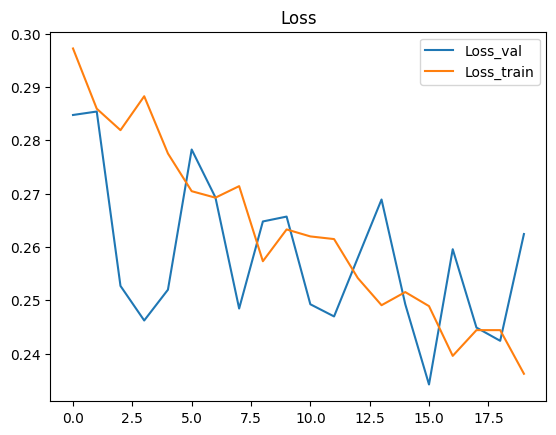

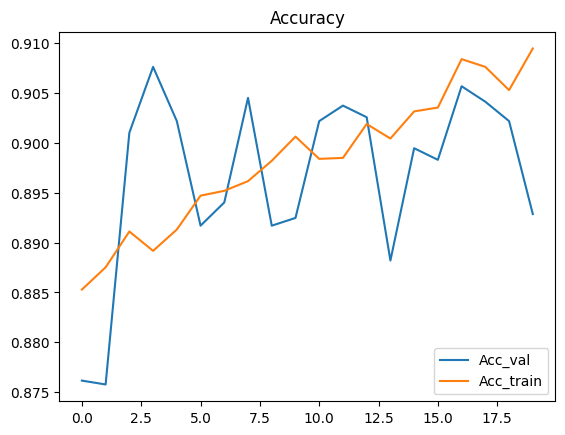

In [19]:
import matplotlib.pyplot as plt

loss_curve = history["loss"]
loss_val = history["val_loss"]
acc_curve = history["sparse_categorical_accuracy"]
acc_val = history["val_sparse_categorical_accuracy"]

plt.plot(loss_val, label="Loss_val")
plt.plot(loss_curve, label="Loss_train")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(acc_val, label="Acc_val")
plt.plot(acc_curve, label="Acc_train")
plt.legend()
plt.title("Accuracy")
plt.show()

#GRAD CAM - HEATMAP

Let's visualize the areas of interest that the model used to make predictions.

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import glob
from PIL import Image

In [4]:
img_size = (256, 256)
preprocess_input = tf.keras.applications.xception.preprocess_input

last_conv_layer_name = "block14_sepconv2_act"
classifier_layer_names = ["sequential"]

In [5]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)

    classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = tf.keras.Model(classifier_input, x)

    with tf.GradientTape() as tape:
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    grads = tape.gradient(top_class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(last_conv_layer_output, axis=-1)
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap


In [6]:

covid = "/content/drive/MyDrive/Colab_Notebooks/Project_pneumonia/data_cropped/Covid/images/*"
pneumo = "/content/drive/MyDrive/Colab_Notebooks/Project_pneumonia/data_cropped/Normal/images/*"
normal = "/content/drive/MyDrive/Colab_Notebooks/Project_pneumonia/data_cropped/Viral_Pneumonia/images/*"
covid_test_path = glob.glob(covid)[7]
normal_test_path = glob.glob(pneumo)[7]
viral_test_path = glob.glob(normal)[7]
img_covid = Image.open(glob.glob(covid)[7])
img_normal = Image.open(glob.glob(normal)[7])
img_pneumo = Image.open(glob.glob(pneumo)[7])

In [7]:
glob.glob(covid)[86]

'/content/drive/MyDrive/Colab_Notebooks/Project_pneumonia/data_cropped/Covid/images/COVID-1866.png'

In [10]:
img_array_c = preprocess_input(get_img_array(covid_test_path, size=img_size))
img_array_p = preprocess_input(get_img_array(normal_test_path, size=img_size))
img_array_n = preprocess_input(get_img_array(viral_test_path, size=img_size))


heatmap_c = make_gradcam_heatmap(
    img_array_c, model, last_conv_layer_name, classifier_layer_names
)
heatmap_p = make_gradcam_heatmap(
    img_array_p, model, last_conv_layer_name, classifier_layer_names
)
heatmap_n = make_gradcam_heatmap(
    img_array_n, model, last_conv_layer_name, classifier_layer_names
)

<ipython-input-11-d71151bd1cd1>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


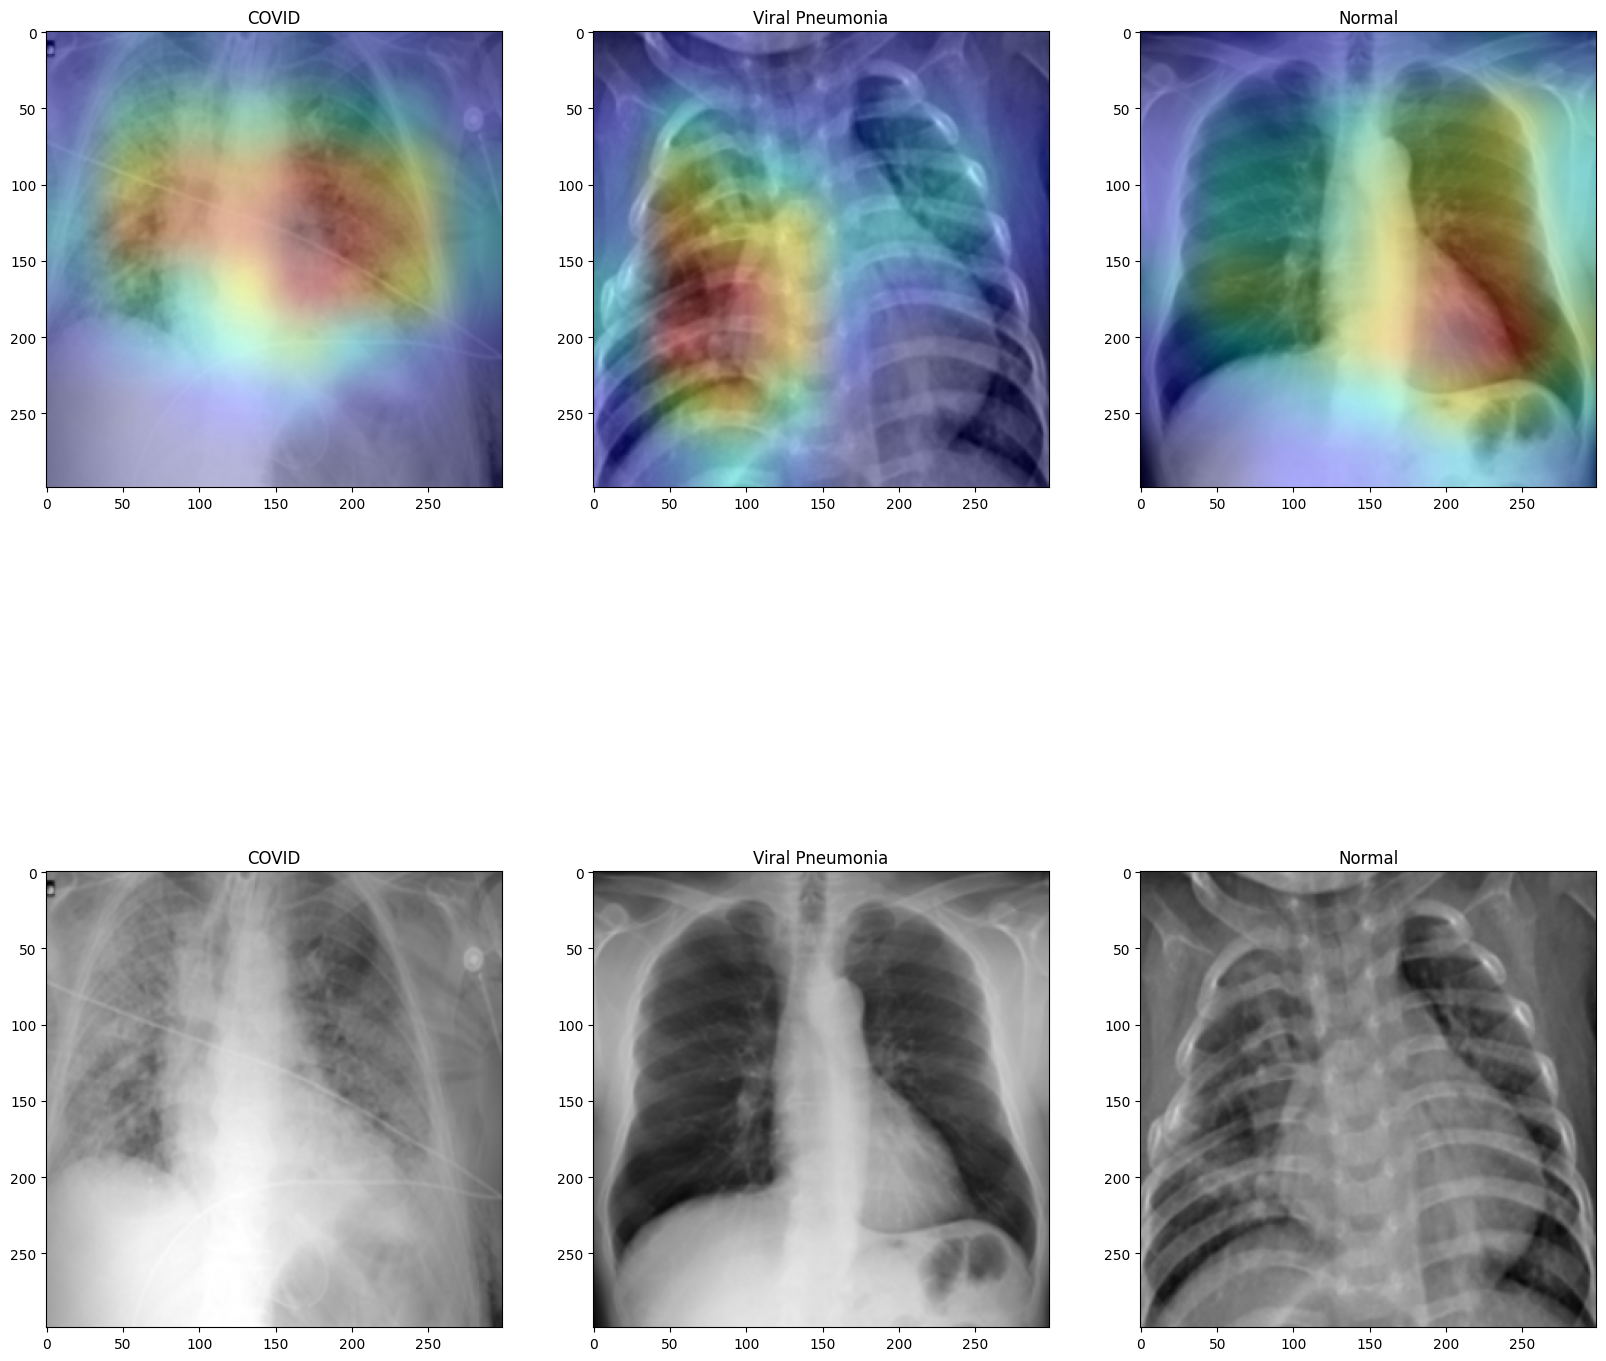

In [11]:


def superpose(path, heatmap):
    img = tf.keras.preprocessing.image.load_img(path)
    img = tf.keras.preprocessing.image.img_to_array(img)
    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)
    superimposed_img = jet_heatmap * 0.4 + img
    return tf.keras.preprocessing.image.array_to_img(superimposed_img)

plt.figure(figsize=(20, 20))

plt.subplot(2, 3, 1)
plt.imshow(superpose(covid_test_path, heatmap_c))
plt.title("COVID")

plt.subplot(2, 3, 2)
plt.imshow(superpose(viral_test_path, heatmap_p))
plt.title("Viral Pneumonia")

plt.subplot(2, 3, 3)
plt.imshow(superpose(normal_test_path, heatmap_n))
plt.title("Normal")

plt.subplot(2, 3, 4)
plt.imshow(img_covid, cmap="binary")
plt.title("COVID")

plt.subplot(2, 3, 5)
plt.imshow(img_pneumo, cmap="binary")
plt.title("Viral Pneumonia")

plt.subplot(2, 3, 6)
plt.imshow(img_normal, cmap="binary")
plt.title("Normal")

plt.show()

Perfect results !

Let's check contrast variability

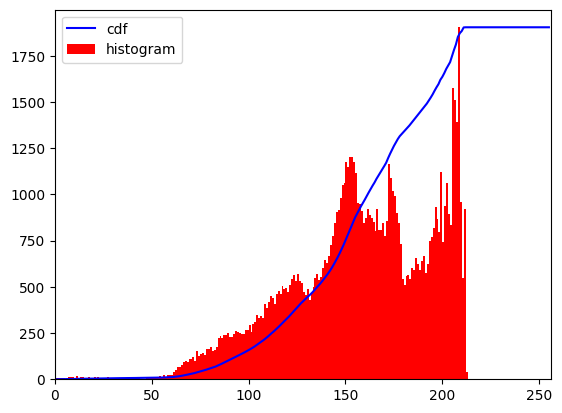

In [14]:
img = cv2.imread('/content/drive/MyDrive/Colab_Notebooks/Project_pneumonia/data_cropped/Covid/images/COVID-1.png',0)
hist,bins = np.histogram(img.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * float(hist.max()) / cdf.max()
plt.plot(cdf_normalized, color = 'b')
plt.hist(img.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

The histogram reveals that the image has moderate to high brightness, with intensity values concentrated between 100 and 200. This narrow range indicates a potential contrast issue, as the image is not utilizing the full intensity range (0-255). As a result, important details may be obscured.

Normalization, such as histogram equalization, can address this by stretching the intensity values to utilize the full range. This process enhances contrast by making dark areas darker and bright areas brighter, which helps to reveal subtle features like anomalies or opacities. Improved contrast not only benefits radiologists but also enhances the performance of machine learning models by making critical details more visible and easier to analyze. Therefore, normalization should be applied to proceed effectively.

#EVALUATE OUR DATA TEST

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [7]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


72/72 ━━━━━━━━━━━━━━━━━━━━ 871s 12s/step - loss: 0.2698 - sparse_categorical_accuracy: 0.9006
Test Loss: 0.2531909644603729, Test Accuracy: 0.9036515355110168


In [8]:
predict = model.predict(test_generator)
y_test = test_generator.classes
y_pred = tf.argmax(predict, axis=1).numpy()

72/72 ━━━━━━━━━━━━━━━━━━━━ 14s 173ms/step


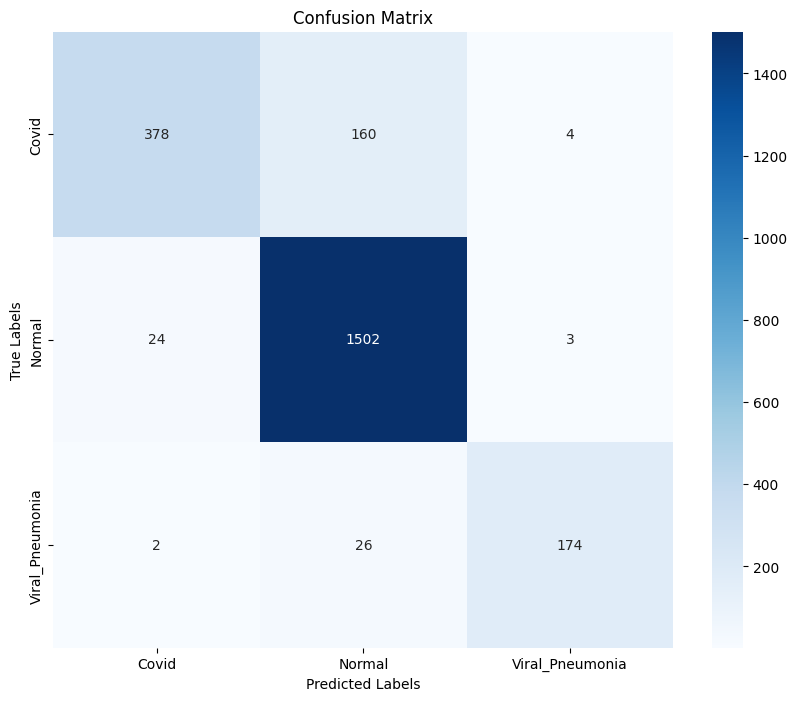

In [9]:
conf_matrix = tf.math.confusion_matrix(y_test, y_pred).numpy()

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [10]:
conf_matrix

array([[ 378,  160,    4],
       [  24, 1502,    3],
       [   2,   26,  174]], dtype=int32)

In [11]:
per_class_accuracy = []
for i in range(len(conf_matrix)):
    true_positives = conf_matrix[i, i]
    total_samples = np.sum(conf_matrix[i, :])
    accuracy = true_positives / total_samples
    per_class_accuracy.append(accuracy)


for idx, acc in enumerate(per_class_accuracy):
    print(f"Class {idx} Accuracy: {acc:.2%}")

Class 0 Accuracy: 69.74%
Class 1 Accuracy: 98.23%
Class 2 Accuracy: 86.14%


#Conclusion

Our model shows great results, but there is still significant room for improvement, especially in the Covid class. The best option would be to add more data, but since this is not always possible, we could consider testing different parameters or trying different models.